# Analysis of National Energy Intensity Data and Socio-Demographic Factors

## Initialise and load data

In [64]:
import os 

import numpy as np
import pandas as pd
import geopandas as gpd

### Energy intensity data by Local Authority District (LAD)

<AxesSubplot:>

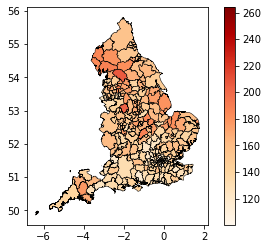

In [94]:
# Read data and make the index the LAD code (allows much easier joining to other data on LAD code)
energy_intensity = gpd.read_file(
    os.path.join("..", "01_Base_Posterior_Sampling/", "Sample_outputs", "energy_intensity_by_lad_since_2000.geojson")).set_index("local_authority", drop=True)

# Drop LSOAs that don't have energy intensity data.
# Note that columns are currently strings, so need to find values with string 'NA',
# not a proper np.nan value.
energy_intensity = energy_intensity.loc[energy_intensity['energy_intensity_mean']!='NA']

# For some reason need to set the numeric columns to be floats 
for col in ['energy_intensity_1stQ', 'energy_intensity_mean',
       'energy_intensity_median', 'energy_intensity_3rdQ',
       'energy_intensity_sd', 'energy_intensity_national_mean',
       'mean_annual_income', 'top_rated_wall_insulation', 'secondary_heating',
       'social_rental', 'private_rental', 'standard_energy_tariff',
       'imd_mean_score',
       'imd_proportion_of_lsoas_in_most_deprived_decile_nationally']:
    # If there are NAs these need to be converted to a proper NA, not a string "NA",
    # otherwise astype() fails
    if (energy_intensity[col]=="NA").any():
        energy_intensity.loc[energy_intensity[col]=="NA", col] = np.nan
    energy_intensity[col] = energy_intensity[col].astype(float)

energy_intensity.plot(column="energy_intensity_mean", cmap='OrRd', edgecolor='k', linewidth=0.5, legend=True)

### Demographic data

#### GIS Data

OA/LSOA/MSOA/LAD lookup so that we can move between different geographies.

From [data.gov.uk](https://data.gov.uk/dataset/ec39697d-e7f4-4419-a146-0b9c9c15ee06/output-area-to-lsoa-to-msoa-to-local-authority-district-december-2017-lookup-with-area-classifications-in-great-britain). Download and compress (it's big as a raw csv file) with
```bash
cd data/gis
wget http://geoportal1-ons.opendata.arcgis.com/datasets/fe6c55f0924b4734adf1cf7104a0173e_0.csv
gzip fe6c55f0924b4734adf1cf7104a0173e_0.csv
```

In [95]:
def get_msoa_column(df, lookup, df_col):
    """Return a Series that contains the MSOA code after doing a lookup for an LSOA or OA value
    in df.
    
    :param df: The input OA / LSOA dataframe
    :param lookup: A dict of '(ls)oa_code -> msoa_code'
    :param df_col: The column in df that represents the (LS)OA codes.
    """
    return df[df_col].apply(func=lambda x: lookup[x])

In [96]:
gis_lookup = pd.read_csv(os.path.join('data', 'gis', 'fe6c55f0924b4734adf1cf7104a0173e_0.csv.gz'))

# Make (LS)OA dictionary lookups
oa_dict = gis_lookup.set_index('OA11CD', drop=True).loc[:,'MSOA11CD'].to_dict()
lsoa_dict = gis_lookup.set_index('LSOA11CD', drop=True).loc[:,'MSOA11CD'].to_dict()
# Check the keys are unique (all keys in oa_dict should be different to those in lsoa_dict)
assert len(set(oa_dict.keys()).difference(set(lsoa_dict.keys()))) == len(oa_dict)
# Combine into a single dict
oa_dict.update(lsoa_dict)
msoa_lookup = oa_dict
assert len(msoa_lookup) == len(gis_lookup['OA11CD'].unique()) + len(gis_lookup['LSOA11CD'].unique())

del oa_dict, lsoa_dict

#### Deprivation (IMD)

Index of Multiple Deprivation (IMD) 2019

Source: https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019

See [README.md](./data/imd/README.md) for details

In [97]:
imd_lsoa = pd.read_csv(os.path.join("data", "imd", 
                                    "File_1_-_IMD2019_Index_of_Multiple_Deprivation.csv.gz"))

# Make the rank numeric (currently string with commas)
col = 'Index of Multiple Deprivation (IMD) Rank'
imd_lsoa[col] = imd_lsoa[col].str.split(',').str.join('').astype(int)

imd_lsoa

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Rank,Index of Multiple Deprivation (IMD) Decile
0,E01000001,City of London 001A,E09000001,City of London,29199,9
1,E01000002,City of London 001B,E09000001,City of London,30379,10
2,E01000003,City of London 001C,E09000001,City of London,14915,5
3,E01000005,City of London 001E,E09000001,City of London,8678,3
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,14486,5
...,...,...,...,...,...,...
32839,E01033764,Liverpool 022E,E08000012,Liverpool,116,1
32840,E01033765,Liverpool 061D,E08000012,Liverpool,945,1
32841,E01033766,Liverpool 042G,E08000012,Liverpool,12842,4
32842,E01033767,Liverpool 050J,E08000012,Liverpool,422,1


In [ ]:
# Aggregate IMD data to local authority district (choose mean rank per LAD)
# (See https://www.statology.org/pandas-groupby-aggregate-multiple-columns/ for multiple aggregation)
col = 'Index of Multiple Deprivation (IMD) Rank'
imd_lad = imd_lsoa.groupby('Local Authority District code (2019)').agg({col: np.mean})

# Merge to the energy data
energy_intensity[col] = energy_intensity.merge(imd_lad, how="left", left_index=True, right_index=True)[col]
# Sanity check the join (not currently because some areas do not join. Leaving for now)
#assert not energy_intensity[col].isna().any()
energy_intensity

#### Tenure 

Table [QS405EW](https://www.nomisweb.co.uk/census/2011/qs405ew) (Tenure - Households). 

Used 'Download (.csv)' box at the bottom to download LAD data.

In [46]:
tenure_lad = pd.read_csv(os.path.join("data", "census", "tenure-households-lad.csv")).set_index('geography code', drop=True)

# Merge to the energy data
#XXXX

#### Accommodation (Building) type

Table [QS402EW](https://www.nomisweb.co.uk/census/2011/qs402ew) (Accomodation type). 

Used 'Download (.csv)' box at the bottom to download LAD data.

In [47]:
accommodation_type_lad = pd.read_csv(os.path.join("data", "census", "accommodation-type-lad.csv")).set_index('geography code', drop=True)

# Merge to the energy data
#XXXX

#### Household type

Table [QS116EW](https://www.nomisweb.co.uk/census/2011/qs116ew) - Household type. 

Used 'Download (.csv)' box at the bottom to download LAD data.

In [48]:
building_type_lad = pd.read_csv(os.path.join("data", "census", "household-type-lad.csv")).set_index('geography code', drop=True)

# Merge to the energy data
#XXXX